# Anomaly Detection using Cluster Analysis in PySpark:

### Read in data from s3 bucket: Data has circa 5m rows and 42 columns 

In [1]:
data = sc.textFile('s3n://cssanalysis/kddcup.data',10).map(lambda x: x.split(','))
print(data.count())
print(data.take(1))

4898431
[[u'0', u'tcp', u'http', u'SF', u'215', u'45076', u'0', u'0', u'0', u'0', u'0', u'1', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'0', u'1', u'1', u'0.00', u'0.00', u'0.00', u'0.00', u'1.00', u'0.00', u'0.00', u'0', u'0', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'0.00', u'normal.']]


### Apply types to each of the values that have been read in. This is done by using a broadcast variable which is a list of tuples with (column indexes,type)

In [2]:
formats = sc.broadcast([(0,'float'),(1,'string'),(2,'string'),(3,'string'),(4,'float'),(5,'float'),(6,'int'),(7,'float'),(8,'float'),(9,'float'),(10,'float'),(11,'int'),(12,'float'),(13,'float'),(14,'float'),(15,'float'),(16,'float'),(17,'float'),(18,'float'),(19,'float'),(20,'int'),(21,'int'),(22,'float'),(23,'float'),(24,'float'),(25,'float'),(26,'float'),(27,'float'),(28,'float'),(29,'float'),(30,'float'),(31,'float'),(32,'float'),(33,'float'),(34,'float'),(35,'float'),(36,'float'),(37,'float'),(38,'float'),(39,'float'),(40,'float'),(41,'string')])

#define a function which applies the formats from the broadcast variable values each element in the RDD
def apply_format(x):
    col_num=0
    for col_format in formats.value:
        if col_format[1]=='int':
            x[col_format[0]]=int(x[col_format[0]])
        elif col_format[1]=='float':
            x[col_format[0]]=float(x[col_format[0]])
        elif col_format[1]=='bool':
            x[col_format[0]]=bool(x[col_format[0]])
    return x

formatted_data = data.map(lambda x: apply_format(x))
print(formatted_data.take(1))

[[0.0, u'tcp', u'http', u'SF', 215.0, 45076.0, 0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, u'normal.']]


### Create a 10% sample (circa 0.5m rows) and persist it in memory. This sample will be used for exploratory analysis

In [3]:
sample = formatted_data.sample(False,0.1)
sample.persist()
sample.count()

489015

### Explore categorical/nominal values in the data. Aim is to look for distinct values and if any categoricals should be omitted from the analysis

In [4]:
#define a function which would for every categorical feature column, look for distinct values and it's frequency
def explore_categoricals():
    index=0
    categoricals = []
    for val in formats.value:
        if val[1] in ('int','string'):
            categoricals.append((val[0],sample.map(lambda x: (x[index],1)).reduceByKey(lambda x,y:x+y).collect()))
        index = index + 1
    return categoricals
categoricals = explore_categoricals()

categoricals
#column 41 is a label, so we will omit that.
#we will use column 1 in our further analysis
#you can possibly include others but will leave them out for now

[(1, [(u'tcp', 186753), (u'udp', 19234), (u'icmp', 283028)]),
 (2,
  [(u'domain', 103),
   (u'private', 109896),
   (u'bgp', 124),
   (u'klogin', 90),
   (u'imap4', 108),
   (u'urh_i', 12),
   (u'pop_3', 205),
   (u'ecr_i', 280833),
   (u'uucp', 106),
   (u'pm_dump', 1),
   (u'printer', 104),
   (u'pop_2', 103),
   (u'netbios_ns', 99),
   (u'http', 62285),
   (u'uucp_path', 125),
   (u'daytime', 96),
   (u'ftp', 496),
   (u'nnsp', 107),
   (u'time', 152),
   (u'ssh', 98),
   (u'discard', 101),
   (u'X11', 17),
   (u'urp_i', 556),
   (u'courier', 100),
   (u'mtp', 111),
   (u'smtp', 9529),
   (u'auth', 366),
   (u'http_443', 103),
   (u'login', 110),
   (u'nntp', 92),
   (u'sql_net', 87),
   (u'name', 109),
   (u'exec', 113),
   (u'efs', 113),
   (u'ntp_u', 365),
   (u'other', 7169),
   (u'csnet_ns', 105),
   (u'shell', 100),
   (u'IRC', 46),
   (u'domain_u', 5689),
   (u'netbios_ssn', 89),
   (u'Z39_50', 113),
   (u'netbios_dgm', 95),
   (u'rje', 113),
   (u'ctf', 109),
   (u'eco_i', 1

### Explore continuous values in the data. This will involve looking at summary statistics and distributions.

In [5]:
#define a function that for each feature in the dataset calculates summary measuresand returns a dict object with feature index as key
#summary statistics include mean, stdev, skew, kurtosis, n
def summary(rdd):
    n = rdd.count()
    mean = rdd.mean()
    stdev = rdd.stdev()
    
    def skewness():
        std_cubed = pow(stdev,3)
        third_moment = moment_mean(3)
        return (third_moment/std_cubed)

    def kurtosis():
        var_squared = pow(stdev,4)
        fourth_moment = moment_mean(4)
        return (fourth_moment/var_squared)

    def moment_mean(order):
        return rdd.map(lambda x: pow(x-mean,order)).reduce(lambda x,y: x+y)/n
    
    return {'n': n,'mean':mean,'stdev':stdev,'skew':skewness(),'kurtosis':kurtosis()}

summary_results = {}
index = 0
for val in formats.value:
    if val[1] in ('float'):
        temp = sample.map(lambda x: x[index])
        summary_results[str(val[0])]=summary(temp)
    index = index + 1

summary_results
#feature 19 looks a bit odd. min, max and mean are all same.

{'0': {'kurtosis': 1035.6876657909668,
  'mean': 46.977317669192438,
  'n': 489015,
  'skew': 27.144901950420543,
  'stdev': 702.87027939323286},
 '10': {'kurtosis': 151734.21591474369,
  'mean': 3.8853613897324152e-05,
  'n': 489015,
  'skew': 356.78012997923321,
  'stdev': 0.010009990794742978},
 '12': {'kurtosis': 294918.64804006187,
  'mean': 0.0047258264061429594,
  'n': 489015,
  'skew': 512.86934385465304,
  'stdev': 1.4475948924683992},
 '13': {'kurtosis': 17462.821485831239,
  'mean': 5.7257957322372712e-05,
  'n': 489015,
  'skew': 132.14318554439291,
  'stdev': 0.0075666821559185636},
 '14': {'kurtosis': 65703.957742618863,
  'mean': 3.0673905708413998e-05,
  'n': 489015,
  'skew': 255.22837293769723,
  'stdev': 0.0077007755116682095},
 '15': {'kurtosis': 290600.69259265182,
  'mean': 0.009402574563152433,
  'n': 489015,
  'skew': 506.79874830912223,
  'stdev': 1.6321180799918462},
 '16': {'kurtosis': 112400.4626194748,
  'mean': 0.00090181282782736513,
  'n': 489015,
  'ske

### Investigate feature number 19 further

In [6]:
print(formatted_data.map(lambda x: x[19]).mean(),formatted_data.map(lambda x: x[19]).min(),formatted_data.map(lambda x: x[19]).max())
#it seems feature 19 should be omitted from our analysis

(0.0, 0.0, 0.0)


### Create histograms to analyze distrubutions of features

In [7]:
#define a function with creates histograms for every continuous feature in the dataset
def histograms():
    histograms={}
    index = 0
    for val in formats.value:
        if val[1] in ('float'):
            histograms[str(val[0])]=sample.map(lambda x: x[index]).histogram(20)
        index = index + 1
    return histograms
histograms = histograms()
histograms

{'0': ([0.0,
   2133.9499999999998,
   4267.8999999999996,
   6401.8499999999995,
   8535.7999999999993,
   10669.75,
   12803.699999999999,
   14937.649999999998,
   17071.599999999999,
   19205.549999999999,
   21339.5,
   23473.449999999997,
   25607.399999999998,
   27741.349999999999,
   29875.299999999996,
   32009.249999999996,
   34143.199999999997,
   36277.149999999994,
   38411.099999999999,
   40545.049999999996,
   42679.0],
  [485225,
   2192,
   582,
   308,
   240,
   111,
   106,
   92,
   39,
   34,
   22,
   4,
   13,
   4,
   15,
   1,
   0,
   9,
   9,
   9]),
 '10': ([0.0,
   0.25,
   0.5,
   0.75,
   1.0,
   1.25,
   1.5,
   1.75,
   2.0,
   2.25,
   2.5,
   2.75,
   3.0,
   3.25,
   3.5,
   3.75,
   4.0,
   4.25,
   4.5,
   4.75,
   5.0],
  [489004, 0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]),
 '12': ([0.0,
   44.200000000000003,
   88.400000000000006,
   132.60000000000002,
   176.80000000000001,
   221.0,
   265.20000000000005,
   309.40000000000

In [8]:
sample.unpersist()

PythonRDD[7] at RDD at PythonRDD.scala:43

### Create indicator/dummy columns for categorical features. eg: feature no 1: had values 'tcp','udp','icmp'. This will be transformed into three indicator columns: eg 'tcp' becomes 1,0,0. 'udp' becomes 0,1,0. and 'icmp' becomes 0,0,1

In [9]:
def dummy(x,values):
    dummy_vars = [0]*len(values)
    count=0
    y=[]
    for items in values:
        if items==x:
            dummy_vars[count]=1
            y = dummy_vars
        count=count+1
    return y

protocol_values = formatted_data.map(lambda x: x[1]).distinct().collect()
protocol_dummied = formatted_data.map(lambda x: dummy(x[1],protocol_values))
categorical_transformed= formatted_data.zip(protocol_dummied).map(lambda x: x[0]+x[1])
print(categorical_transformed.take(2))


[[0.0, u'tcp', u'http', u'SF', 215.0, 45076.0, 0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, u'normal.', 1, 0, 0], [0.0, u'tcp', u'http', u'SF', 162.0, 4528.0, 0, 0.0, 0.0, 0.0, 0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, u'normal.', 1, 0, 0]]


### Standardize continuous features. The function computes the z-score for each continuous feature.

In [11]:
summary_stats = sc.broadcast(summary_results)
#define a function which calculates zscores for each of the features
def zscore(x):
    index = 0
    y=[]
    for val in x:
        if type(val)==float:
            y = y + [ (val - summary_stats.value[str(index)]['mean'])/ summary_stats.value[str(index)]['stdev']]
        else:
            y = y + [val]
        index = index + 1
    return y

standardized = categorical_transformed.map(lambda x: zscore(x))
standardized.persist()
print(standardized.count())
print(standardized.take(2))


4898431
[[-0.066836397905096462, u'tcp', u'http', u'SF', -0.019411321517688717, 3.2139469763327262, 0, -0.015688640947718952, -0.0014300109191760558, -0.026042645874286077, -0.0038814834792584622, 1, -0.0032646056094358064, -0.0075671154334910522, -0.0039832229444861644, -0.0057609646498122287, -0.0084342835936279687, -0.0084727407497239421, -0.027896032268833554, nan, 0, 0, -1.5764461247594126, -1.1970965881020674, -0.46557103543447642, -0.4652589109257747, -0.2489380275856552, -0.24871741818561133, 0.53943387091085249, -0.25581385533940887, -0.20013929391871021, -3.6320839854138933, -1.7876375501351216, -1.8337559575487097, -0.28240031450157743, -1.2591389298169802, -0.15690259947998864, -0.46603510180847618, -0.4650191722473293, -0.25145022916011894, -0.25023778803586993, u'normal.', 1, 0, 0], [-0.066836397905096462, u'tcp', u'http', u'SF', -0.020834921688326923, 0.28213902556522219, 0, -0.015688640947718952, -0.0014300109191760558, -0.026042645874286077, -0.0038814834792584622, 1, 

### Seperate out features which are not needed in the analysis i.e. label and other categorical features which we did not include

In [12]:
label = standardized.map(lambda x: x.pop(41))
print(label.take(2))

def get_features(x,reject):
    rejects = sorted(reject,reverse=True)
    for item in rejects:
        del x[item]
    return x

features = standardized.map(lambda x: get_features(x,[19,41,1,2,3]))
features.persist()
print(features.count())
print(features.take(2))
standardized.unpersist()

[u'normal.', u'normal.']
4898431
[[-0.066836397905096462, -0.019411321517688717, 3.2139469763327262, 0, -0.015688640947718952, -0.0014300109191760558, -0.026042645874286077, -0.0038814834792584622, 1, -0.0032646056094358064, -0.0075671154334910522, -0.0039832229444861644, -0.0057609646498122287, -0.0084342835936279687, -0.0084727407497239421, -0.027896032268833554, 0, 0, -1.5764461247594126, -1.1970965881020674, -0.46557103543447642, -0.4652589109257747, -0.2489380275856552, -0.24871741818561133, 0.53943387091085249, -0.25581385533940887, -0.20013929391871021, -3.6320839854138933, -1.7876375501351216, -1.8337559575487097, -0.28240031450157743, -1.2591389298169802, -0.15690259947998864, -0.46603510180847618, -0.4650191722473293, -0.25145022916011894, -0.25023778803586993, 1, 0, 0], [-0.066836397905096462, -0.020834921688326923, 0.28213902556522219, 0, -0.015688640947718952, -0.0014300109191760558, -0.026042645874286077, -0.0038814834792584622, 1, -0.0032646056094358064, -0.0075671154334

PythonRDD[312] at RDD at PythonRDD.scala:43

### With cluster analysis we need to find the optimal K (i.e. the number of clusters). We do this by simulating a sequence of k's and analyzing the distance measure of each row with their assigned clusters. 

In [13]:
from pyspark.mllib.clustering import KMeans
from numpy import array
import math

def findK():
    x = []
    y = []
    def distance(point):
        assigned_cluster = model.predict(point)
        center = model.clusterCenters[assigned_cluster]
        difference = point-center
        L2 = 0
        for x in difference:
            L2 = L2 + x**2
        return math.sqrt(L2)

    for i in range(5,17,2):
        model = KMeans.train(features.map(lambda x: array(x)),i,maxIterations=10,
        runs=10, initializationMode="random")
        x.append(i)
        y.append(features.map(lambda x: distance(array(x))).reduce(lambda x,y:x+y))
    return x,y

x,y = findK()
print(x,y)

([5, 7, 9, 11, 13, 15], [5569987.923663022, 5141141.830513698, 4569475.8742496315, 4268777.3936149953, 4406705.9407464461, 3449142.7300372873])


### Create a plot to visualize the plot of k agaisnt the RSSE

<function IPython.kernel.zmq.pylab.backend_inline.show>

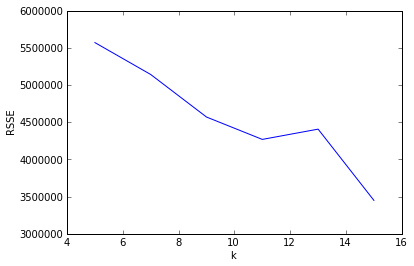

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x,y)
plt.ylabel('RSSE')
plt.xlabel('k')
plt.show    